In [1]:
import matplotlib.pyplot as plt
import folium
from folium import Popup, PolyLine
from streamlit_folium import st_folium
import altair as alt
import pandas as pd
import gpxpy
import util as util
import gpx_utils as gpx_utils

import os


2025-08-13 00:23:29.832 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [2]:
from IPython.display import display, HTML

def folium_deepnote_show(m):
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 609px;', 1)
    display(HTML(data_fixed_height))

In [3]:
fichier = 'Lac_de_la_thuile_par_Curienne'
try:
    gpx_file = open(os.path.join("../traces", f"{fichier}.gpx"), "r")
    gpx = gpxpy.parse(gpx_file)
except IOError:
    print("Couldn't open the input GPX file. Ensure it's in the 'input' dir.")
    raise()

In [4]:
# file = os.path.join("./traces", f"{fichier}.gpx")
track_df, slopes_df, track_df_merge, places_df = gpx_utils.parse_gpx(gpx)


[[np.float64(0.0), 'Bassens, Dralis', np.float64(266.8), 0], [np.float64(1.0), 'Bassens, Bolliet', np.float64(274.8), 0], [np.float64(2.0), 'Saint-Alban-Leysse, Zone commerciale Chambéry Est (Bassens et Saint-Alban-Leysse)', np.float64(282.2), 0], [np.float64(3.0), 'La Ravoire, Le Sablon', np.float64(294.2), 0], [np.float64(4.0), 'Saint-Alban-Leysse, Les Corniolles', np.float64(325.8), 0], [np.float64(5.0), 'Barby, Route de la Bâthie et des Corniolles', np.float64(385.8), 0], [np.float64(6.0), 'Barby, Route de Curienne', np.float64(461.4), 0], [np.float64(7.0), 'Curienne, Route de la Bâthie', np.float64(511.0), 0], [np.float64(8.0), 'Curienne, Route de la Bâthie', np.float64(597.4), 0], [np.float64(9.0), 'Curienne, ', np.float64(653.4), 0], [np.float64(10.0), 'Curienne, ', np.float64(678.6), 0], [np.float64(11.0), 'Curienne, Chemin de Boyat', np.float64(652.8), 0], [np.float64(12.0), 'Curienne, Montgelas', np.float64(713.6), 0], [np.float64(13.0), 'La Thuile, ', np.float64(760.8), 0], 

In [5]:
places_data, last_place, place_group = [], '', 0

for segment in track_df['segment'].unique():
    seg_rows = track_df[track_df['segment'] == segment]
    lat, lon = seg_rows.iloc[0]['latitude'], seg_rows.iloc[0]['longitude']
    location = util.getLocationFromCoords(lat, lon)
    # print(location)
    # if not location:
    #     continue
    props = location['properties']
    # place_name = util.getPlaceName(props)
    
    name = f"{props["city"]}"
    places_data.append([segment, name, seg_rows.iloc[0]['elevation'], place_group])

places_df = pd.DataFrame(places_data, columns=['segment', 'place', 'elevation', 'group'])
# places_df = places_df.sort_values('group').drop_duplicates(subset=['group'], keep='first')


In [6]:
total_distance = track_df['km'].max()
total_climb = track_df['elevation'].diff()

total_climb_pos = total_climb[total_climb > 0].sum()
total_climb_neg = total_climb[total_climb < 0].sum()

print(f"Total distance: {total_distance:.2f} km")
print(f"Total elevation gain: {total_climb_pos:.0f} m")
print(f"Total elevation loss: {total_climb_neg:.0f} m")

Total distance: 39.00 km
Total elevation gain: 771 m
Total elevation loss: -765 m


In [7]:
climbs_df = gpx_utils.detect_climbs(track_df_merge, slopes_df)


In [8]:

# Map with slopes and climbs
m = folium.Map(location=[track_df['latitude'].mean(), track_df['longitude'].mean()], zoom_start=13)
colors = ['black', 'yellow', 'orange', 'orangered', 'maroon', 'darkred', 'purple']
slopesTable = [lambda x: x < 2, lambda x: (x >= 2) & (x < 4), lambda x: (x >= 4) & (x < 5),
               lambda x: (x >= 5) & (x < 8), lambda x: (x >= 8) & (x < 10),
               lambda x: (x >= 10) & (x < 12), lambda x: x >= 12]

# Draw GPX with slope colors
for seg_id in track_df_merge['segment'].unique():
    seg_data = track_df_merge[track_df_merge['segment'] == seg_id]
    slope_val = seg_data['slope'].iloc[0]
    for idx, func in enumerate(slopesTable):
        if func(slope_val):
            color = colors[idx]
            break
    coords = list(zip(seg_data['latitude'], seg_data['longitude']))
    folium.PolyLine(coords, color=color, weight=4).add_to(m)

# Distance markers every 1 km
km_markers = (
    track_df.groupby(track_df['km'].round().astype(int))
    .first()
    .rename_axis("km_marker")
    .reset_index()
)
for _, row in km_markers.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black;">{int(row['km'])} km</div>""")
    ).add_to(m)

# Add climbs slopes with annotations
    #TODO

# folium_deepnote_show(m)


C:\Users\Thibaut\AppData\Local\Temp\ipykernel_17168\3375856262.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


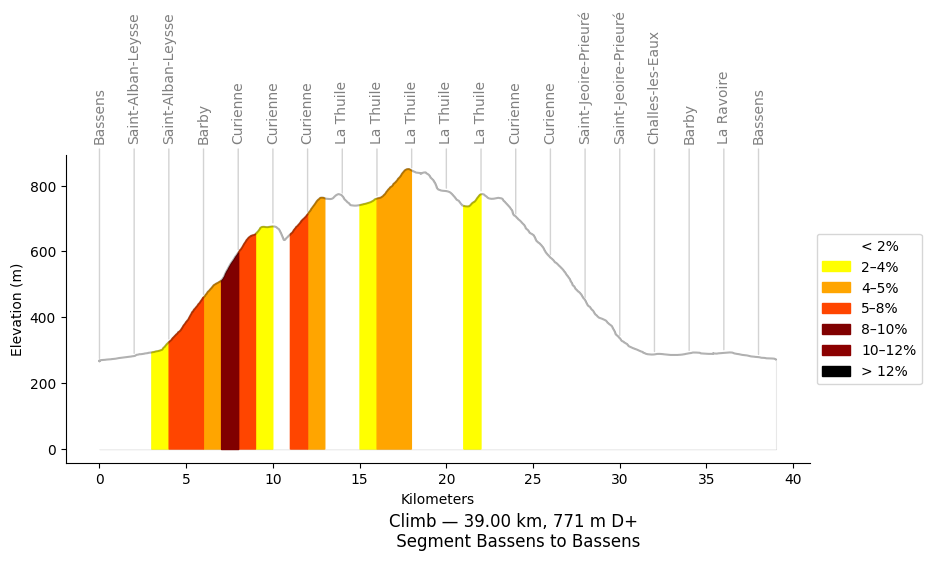

In [9]:
# fig, ax = plt.subplots(figsize=(12, 4))
fig = util.plot_climb_segment(track_df_merge, places_df, track_df['segment'].min(), track_df['segment'].max())
fig.show()


C:\Users\Thibaut\AppData\Local\Temp\ipykernel_17168\4085437145.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


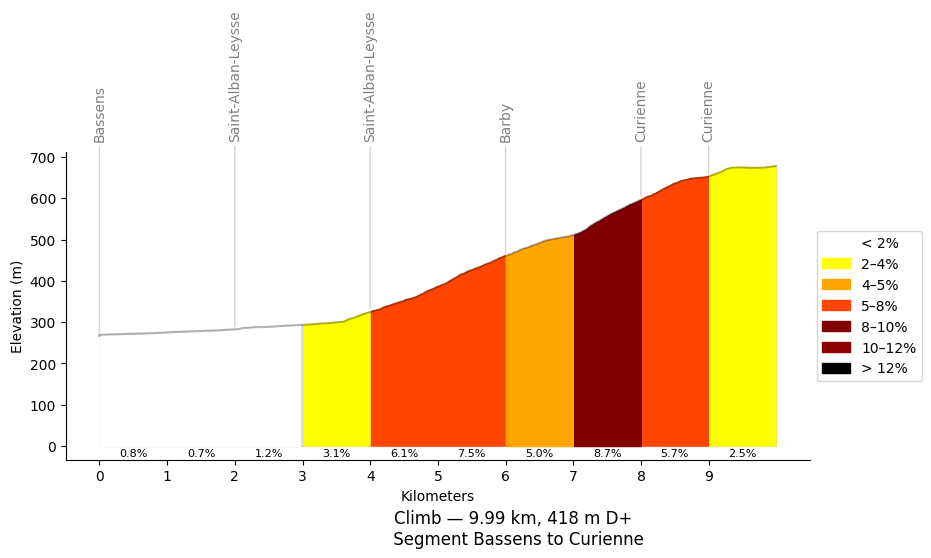

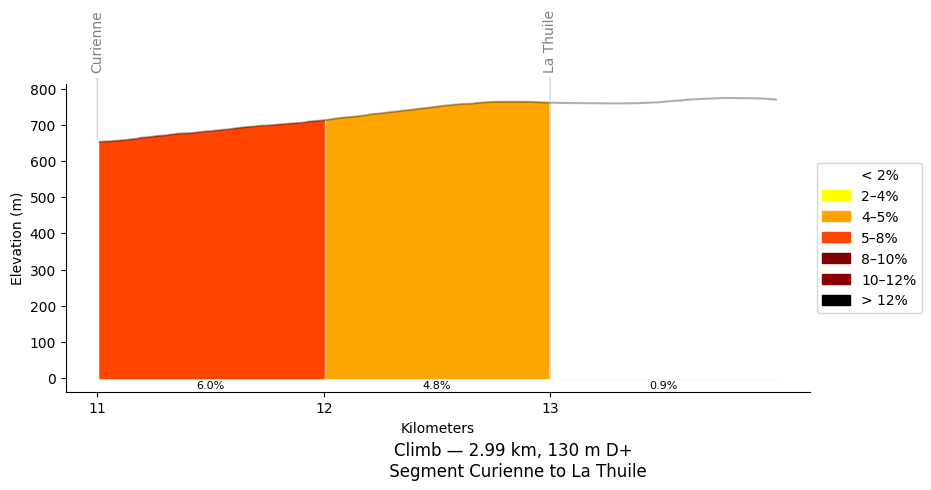

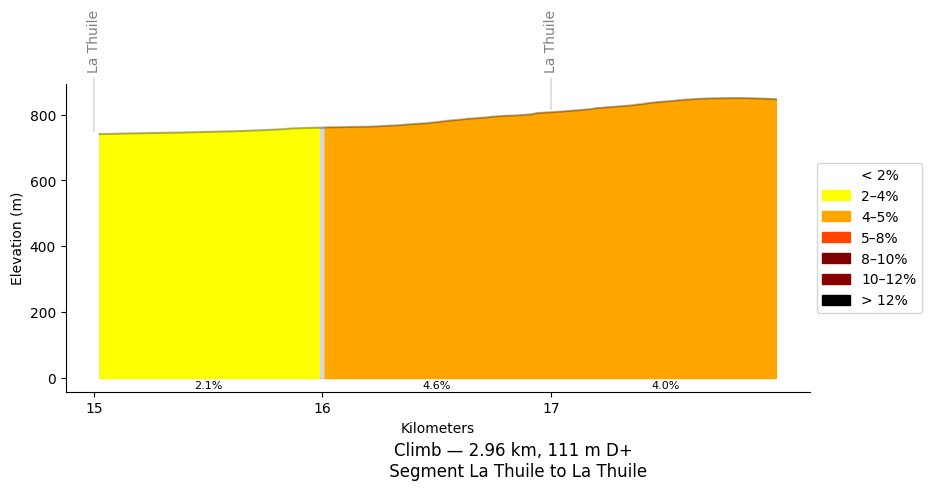

In [10]:
climbs_df = gpx_utils.detect_climbs(track_df_merge, slopes_df)
for _, climb in climbs_df.iterrows():
    fig2 = util.plot_climb_segment(track_df_merge, places_df, climb['segment_min'], climb['segment_max'], True)
    fig2.show()